In [44]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
from keras.losses import mean_squared_error

seed = 7
tf.random.set_seed(seed)

In [45]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [46]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [67]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"], 
            patience=early_stopping["patience"], 
            min_delta=early_stopping["delta"], 
        )
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    nesterov = config["nesterov"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
    
    if momentum != None:
        optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        optimizer = SGD(learning_rate=lr)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    model.add(Input(input_size))
    
    for l in range(1,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        model.add(Dense(n_units, activation=activation,
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        
    if task == "classification":
        model.add(Dense(output_size, activation="sigmoid",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        model.add(Dense(output_size, activation="linear",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = [mee])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    callbacks = get_callbacks(config)

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=callbacks, verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]

    
    callbacks = get_callbacks(config)
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    
def fit_model_test(x_train, y_train, x_test, y_test, config):
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        test_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        test_metric = "val_mee"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"
        
    callbacks = get_callbacks(config)
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_test_loss = []
    trials_train_loss = []
    trials_test_acc = []
    trials_train_acc = []
    
    trials_history_test_loss = []
    trials_history_train_loss = []
    trials_history_test_acc = []
    trials_history_train_acc = []   
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_test, y_test),
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_test_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_test_acc = history.history[test_metric]

            trials_test_loss.append(trial_test_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_test_acc.append(trial_test_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_test_loss.append(trial_test_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_test_acc.append(trial_test_acc)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} test_loss: {trial_test_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} test_{train_metric}: {trial_test_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_test_loss)
    med_test_loss = trials_test_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_test_acc = trials_test_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_test_loss = np.std(trials_test_loss)
    std_train_loss = np.std(trials_train_loss)
    std_test_acc = np.std(trials_test_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian test_loss: {med_test_loss}, std test_loss {std_test_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median test_{train_metric}: {med_test_acc}, std test_{train_metric} {std_test_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    test_acc = trials_history_test_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}", test_acc, f"Test {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    test_loss = trials_history_test_loss[med_idx]
    plot_curves(train_loss, "Train loss", test_loss, "Test loss")
    
    med_model = models[med_idx]
    
    return med_model


def fit_model_no_test(x_train, y_train, config):
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
    elif task == "regression":
        train_metric = "mee"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    trials = config["trials_test"]
    
    if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"
        
    callbacks = get_callbacks(config)
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_train_loss = []
    trials_train_acc = []
    
    trials_history_train_loss = []
    trials_history_train_acc = []   
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs,
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_train_acc = history.history[train_metric]

            trials_train_loss.append(trial_train_loss[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_train_loss.append(trial_train_loss)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc}")

            pbar.update(1)
        
    med_idx = median_index(trials_train_loss)
    med_train_loss = trials_train_loss[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_train_loss = np.std(trials_train_loss)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
    
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    plot_curves(train_loss, f"Train loss")
    
    med_model = models[med_idx]
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scale:
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}, x_test=None, y_test=None ):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    if x_test is None:
        model = fit_model_no_test(x_train, y_train, best_conf)
    else:
        model = fit_model_test(x_train, y_train, x_test, y_test, best_conf)
        
    return model

In [ ]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.8],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [5],
        },
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "learning_rate_decay": {
        "epochs": 50,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.0001, 0.001]
        },
        {
            "type": "l2",
            "value": [0.0001, 0.001]
        },
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

# Monks 1

In [114]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


100%|███████████████████████████████████████| 5/5 [00:42<00:00,  8.56s/it]


Median val_loss: 0.01510387659072876, std val_loss 0.03571847958857039
Median train_loss: 0.003445442533120513, std train_loss 0.032321490824888444
Median val_accuracy: 1.0, std val_accuracy 0.04210526943206787
Median train_accuracy: 1.0, train_accuracy 0.026666665077209474






Best configuration (loss 0.01510387659072876):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


 10%|███▊                                  | 1/10 [00:19<02:57, 19.76s/it]

Trial 1/10 test_loss: 0.0031176123302429914
Trial 1/10 train_loss: 0.0020067079458385706
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0


 20%|███████▌                              | 2/10 [00:32<02:03, 15.44s/it]

Trial 2/10 test_loss: 0.0053355018608272076
Trial 2/10 train_loss: 0.0034159563947468996
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0


 30%|███████████▍                          | 3/10 [00:41<01:30, 12.86s/it]

Trial 3/10 test_loss: 0.019767988473176956
Trial 3/10 train_loss: 0.0022381742019206285
Trial 3/10 val_accuracy: 0.9791666865348816
Trial 3/10 train_accuracy: 1.0


 40%|███████████████▏                      | 4/10 [00:51<01:09, 11.63s/it]

Trial 4/10 test_loss: 0.006597463507205248
Trial 4/10 train_loss: 0.0038097365759313107
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|███████████████████                   | 5/10 [01:00<00:53, 10.70s/it]

Trial 5/10 test_loss: 0.08800572156906128
Trial 5/10 train_loss: 0.06753717362880707
Trial 5/10 val_accuracy: 0.9166666865348816
Trial 5/10 train_accuracy: 0.9354838728904724


 60%|██████████████████████▊               | 6/10 [01:14<00:46, 11.67s/it]

Trial 6/10 test_loss: 0.08973483741283417
Trial 6/10 train_loss: 0.043330464512109756
Trial 6/10 val_accuracy: 0.9166666865348816
Trial 6/10 train_accuracy: 0.9596773982048035


 70%|██████████████████████████▌           | 7/10 [01:26<00:35, 11.82s/it]

Trial 7/10 test_loss: 0.007058745715767145
Trial 7/10 train_loss: 0.0026478224899619818
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0


 80%|██████████████████████████████▍       | 8/10 [01:38<00:23, 11.78s/it]

Trial 8/10 test_loss: 0.013033948838710785
Trial 8/10 train_loss: 0.004240756388753653
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|██████████████████████████████████▏   | 9/10 [01:53<00:12, 12.76s/it]

Trial 9/10 test_loss: 0.009093061089515686
Trial 9/10 train_loss: 0.004414776805788279
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|█████████████████████████████████████| 10/10 [02:06<00:00, 12.64s/it]

Trial 10/10 test_loss: 0.009019430726766586
Trial 10/10 train_loss: 0.0029675872065126896
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0

Median test_loss: 0.009093061089515686, std test_loss 0.03219519322004243
Median train_loss: 0.004414776805788279, std train_loss 0.021589589575437322
Median test_accuracy: 1.0, std test_accuracy 0.03287443756364674
Median train_accuracy: 1.0, std train_accuracy 0.021654392083156903


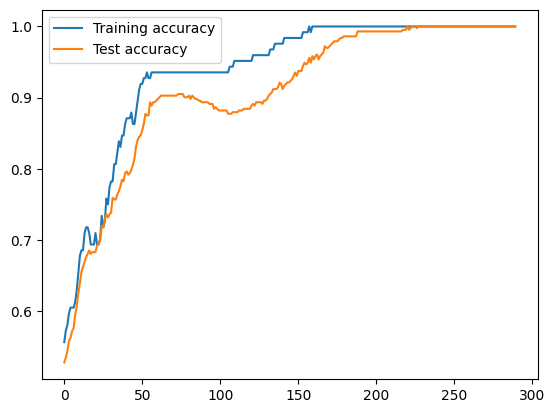

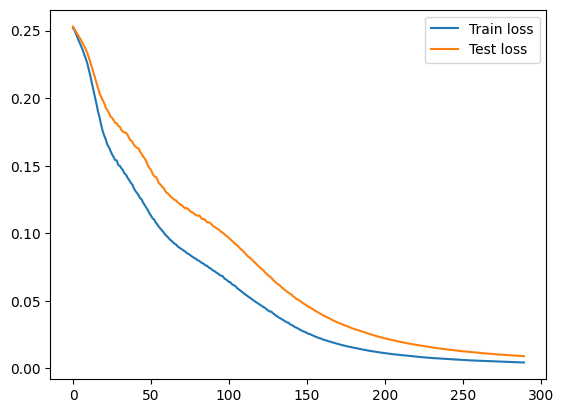

14/14 [==============================] - 0s 2ms/step - loss: 0.0091 - accuracy: 1.0000
[0.009093061089515686, 1.0]


In [15]:
model = grid_search(params, x_train, y_train, hold_out_val, x_test, y_test)
test_model(model, x_test, y_test)

# Monks 2

In [16]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


100%|███████████████████████████████████████| 5/5 [00:32<00:00,  6.53s/it]


Median val_loss: 0.0034551406279206276, std val_loss 0.00031941248656808594
Median train_loss: 0.003039245493710041, std train_loss 0.00028023925188884826
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 1.0, train_accuracy 0.0






Best configuration (loss 0.0034551406279206276):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


 10%|███▊                                  | 1/10 [00:10<01:38, 10.95s/it]

Trial 1/10 test_loss: 0.0029125374276190996
Trial 1/10 train_loss: 0.0027554656844586134
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0


 20%|███████▌                              | 2/10 [00:25<01:44, 13.06s/it]

Trial 2/10 test_loss: 0.059759777039289474
Trial 2/10 train_loss: 0.03260529413819313
Trial 2/10 val_accuracy: 0.9444444179534912
Trial 2/10 train_accuracy: 0.9704142212867737


 30%|███████████▍                          | 3/10 [00:33<01:15, 10.85s/it]

Trial 3/10 test_loss: 0.002268277108669281
Trial 3/10 train_loss: 0.002316349186003208
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0


 40%|███████████████▏                      | 4/10 [00:41<00:57,  9.56s/it]

Trial 4/10 test_loss: 0.002395757008343935
Trial 4/10 train_loss: 0.0022378843277692795
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|███████████████████                   | 5/10 [00:47<00:41,  8.39s/it]

Trial 5/10 test_loss: 0.0021820419933646917
Trial 5/10 train_loss: 0.0019720480777323246
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0


 60%|██████████████████████▊               | 6/10 [01:04<00:45, 11.32s/it]

Trial 6/10 test_loss: 0.15185493230819702
Trial 6/10 train_loss: 0.10768608003854752
Trial 6/10 val_accuracy: 0.7800925970077515
Trial 6/10 train_accuracy: 0.8461538553237915


 70%|██████████████████████████▌           | 7/10 [01:12<00:30, 10.28s/it]

Trial 7/10 test_loss: 0.002956053940579295
Trial 7/10 train_loss: 0.00278883776627481
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0


 80%|██████████████████████████████▍       | 8/10 [01:22<00:20, 10.09s/it]

Trial 8/10 test_loss: 0.0035104909911751747
Trial 8/10 train_loss: 0.0025382009334862232
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|██████████████████████████████████▏   | 9/10 [01:33<00:10, 10.34s/it]

Trial 9/10 test_loss: 0.003969848621636629
Trial 9/10 train_loss: 0.0023757375311106443
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|█████████████████████████████████████| 10/10 [01:40<00:00, 10.03s/it]

Trial 10/10 test_loss: 0.0023393614683300257
Trial 10/10 train_loss: 0.0020424500107765198
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0

Median test_loss: 0.002956053940579295, std test_loss 0.04605973879203295
Median train_loss: 0.00278883776627481, std train_loss 0.03188581882938619
Median test_accuracy: 1.0, std test_accuracy 0.06622514852733462
Median train_accuracy: 1.0, std train_accuracy 0.04602089469139655


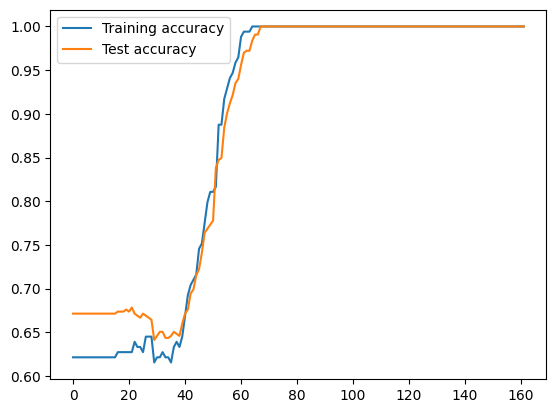

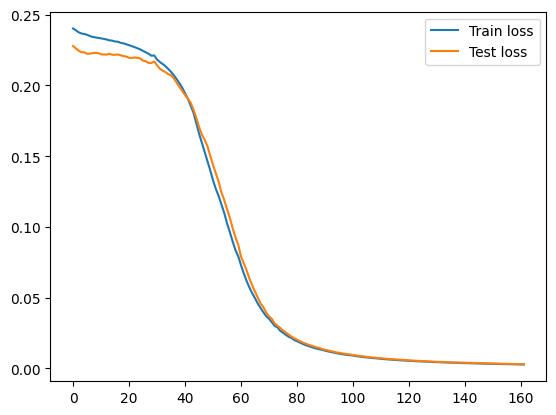

14/14 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
[0.002956053940579295, 1.0]


In [17]:
model = grid_search(params, x_train, y_train, hold_out_val, x_test, y_test)
test_model(model, x_test, y_test)

# Monks 3

In [37]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [32],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": "l2",
            "value": [0.005]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}



k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

In [38]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


Testing configuration 1/1:
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l2', 'value': 0.005}, 'activations_1': 'relu', 'units_1': 8}


100%|█████████████████████████████████████████████| 5/5 [00:15<00:00,  3.03s/it]


Median val_loss: 0.09567485004663467, std val_loss 0.0029708755013925343
Median train_loss: 0.1128501445055008, std train_loss 0.001251332109894439
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9223300814628601, train_accuracy 0.0






Best configuration (loss 0.09567485004663467):
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l2', 'value': 0.005}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:07<01:08,  7.64s/it]

Trial 1/10 test_loss: 0.09026139229536057
Trial 1/10 train_loss: 0.10625527799129486
Trial 1/10 val_accuracy: 0.9722222089767456
Trial 1/10 train_accuracy: 0.9344262480735779


 20%|████████▊                                   | 2/10 [00:14<00:57,  7.16s/it]

Trial 2/10 test_loss: 0.0910329669713974
Trial 2/10 train_loss: 0.10607070475816727
Trial 2/10 val_accuracy: 0.9722222089767456
Trial 2/10 train_accuracy: 0.9344262480735779


 30%|█████████████▏                              | 3/10 [00:27<01:08,  9.74s/it]

Trial 3/10 test_loss: 0.09338313341140747
Trial 3/10 train_loss: 0.10665977746248245
Trial 3/10 val_accuracy: 0.9722222089767456
Trial 3/10 train_accuracy: 0.9344262480735779


 40%|█████████████████▌                          | 4/10 [00:35<00:54,  9.02s/it]

Trial 4/10 test_loss: 0.09312144666910172
Trial 4/10 train_loss: 0.10752646625041962
Trial 4/10 val_accuracy: 0.9722222089767456
Trial 4/10 train_accuracy: 0.9344262480735779


 50%|██████████████████████                      | 5/10 [00:41<00:40,  8.06s/it]

Trial 5/10 test_loss: 0.09078411757946014
Trial 5/10 train_loss: 0.1062244325876236
Trial 5/10 val_accuracy: 0.9722222089767456
Trial 5/10 train_accuracy: 0.9344262480735779


 60%|██████████████████████████▍                 | 6/10 [00:49<00:32,  8.17s/it]

Trial 6/10 test_loss: 0.09347494691610336
Trial 6/10 train_loss: 0.10724097490310669
Trial 6/10 val_accuracy: 0.9722222089767456
Trial 6/10 train_accuracy: 0.9344262480735779


 70%|██████████████████████████████▊             | 7/10 [00:57<00:24,  8.10s/it]

Trial 7/10 test_loss: 0.09330945461988449
Trial 7/10 train_loss: 0.1075175479054451
Trial 7/10 val_accuracy: 0.9722222089767456
Trial 7/10 train_accuracy: 0.9344262480735779


 80%|███████████████████████████████████▏        | 8/10 [01:04<00:15,  7.57s/it]

Trial 8/10 test_loss: 0.09038995951414108
Trial 8/10 train_loss: 0.10642141103744507
Trial 8/10 val_accuracy: 0.9722222089767456
Trial 8/10 train_accuracy: 0.9344262480735779


 90%|███████████████████████████████████████▌    | 9/10 [01:10<00:07,  7.13s/it]

Trial 9/10 test_loss: 0.09100321680307388
Trial 9/10 train_loss: 0.10619311779737473
Trial 9/10 val_accuracy: 0.9722222089767456
Trial 9/10 train_accuracy: 0.9344262480735779


100%|███████████████████████████████████████████| 10/10 [01:17<00:00,  7.76s/it]

Trial 10/10 test_loss: 0.09052447229623795
Trial 10/10 train_loss: 0.10637059062719345
Trial 10/10 val_accuracy: 0.9722222089767456
Trial 10/10 train_accuracy: 0.9344262480735779

Median test_loss: 0.0910329669713974, std test_loss 0.0013237463849026956
Median train_loss: 0.10607070475816727, std train_loss 0.0005368147268636532
Median test_accuracy: 0.9722222089767456, std test_accuracy 0.0
Median train_accuracy: 0.9344262480735779, std train_accuracy 0.0


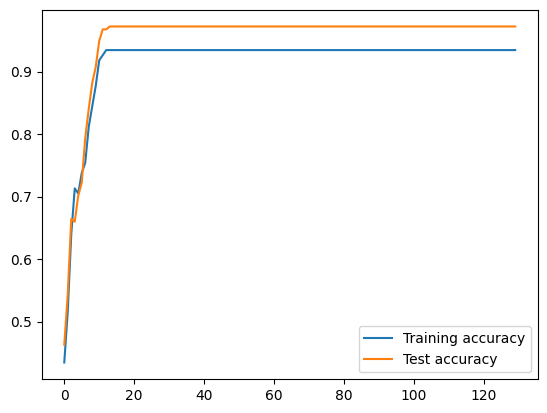

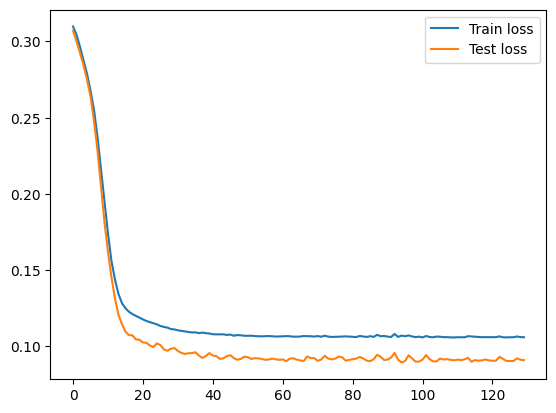

14/14 [==============================] - 0s 1ms/step - loss: 0.0910 - accuracy: 0.9722
[0.0910329669713974, 0.9722222089767456]


In [39]:
model = grid_search(params, x_train, y_train, hold_out_val, x_test, y_test)
test_model(model, x_test, y_test)

# ML Cup

In [61]:
x_train, y_train, x_test, y_test = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
#print(x_test_blind.shape)

(1343, 9) (1343, 2)
(149, 9) (149, 2)


In [77]:
params = {
    "task": "regression",
    "trials_train": 5,
    "trials_test": 5,
    "initialization": {
        "type": "uniform",
        "min": -0.75,
        "max": 0.75
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [32],
    "nesterov": False,
    "momentum": [0.9],
    "learning_rate_decay": {
        "epochs": 100,
        "lr_final": 0.0001
    },
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [10],
        },
        {
            "activations": ["relu"],
            "units": [10],
        },
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/2:
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.75, 'max': 0.75}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0}, 'task': 'regression', 'trials_train': 5, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.0001}, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 10}


100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.59s/it]


Median val_loss: 0.08638183027505875, std val_loss 0.004679900903843621
Median train_loss: 0.08593886345624924, std train_loss 0.004455226463639373
Median val_mee: 0.3289380967617035, std val_mee 0.009240531414419809
Median train_mee: 0.31843551993370056, train_mee 0.010355741321135018



Testing configuration 2/2:
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.75, 'max': 0.75}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0}, 'task': 'regression', 'trials_train': 5, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.0001}, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 10, 'activations_2': 'relu', 'units_2': 10}


100%|█████████████████████████████████████████████| 5/5 [00:21<00:00,  4.34s/it]


Median val_loss: 0.08873496949672699, std val_loss 0.14367114243919954
Median train_loss: 0.0736466571688652, std train_loss 0.1209668869564161
Median val_mee: 0.32980093359947205, std val_mee 0.20318580774384612
Median train_mee: 0.283589243888855, train_mee 0.1822201802666014






Best configuration (loss 0.08638183027505875):
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.75, 'max': 0.75}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0}, 'task': 'regression', 'trials_train': 5, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.0001}, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 10}


 20%|█████████                                    | 1/5 [00:37<02:29, 37.32s/it]

Trial 1/5 test_loss: 0.10158909112215042
Trial 1/5 train_loss: 0.08323395997285843
Trial 1/5 test_mee: 0.3424595892429352
Trial 1/5 train_mee: 0.31713053584098816


 40%|██████████████████                           | 2/5 [01:17<01:56, 38.98s/it]

Trial 2/5 test_loss: 0.10058345645666122
Trial 2/5 train_loss: 0.08240271359682083
Trial 2/5 test_mee: 0.3484003245830536
Trial 2/5 train_mee: 0.3138502836227417


 60%|███████████████████████████                  | 3/5 [01:59<01:20, 40.22s/it]

Trial 3/5 test_loss: 0.09229789674282074
Trial 3/5 train_loss: 0.0776498094201088
Trial 3/5 test_mee: 0.3346728980541229
Trial 3/5 train_mee: 0.30602511763572693


 80%|████████████████████████████████████         | 4/5 [02:41<00:40, 40.92s/it]

Trial 4/5 test_loss: 0.09426704794168472
Trial 4/5 train_loss: 0.08445336669683456
Trial 4/5 test_mee: 0.3343776762485504
Trial 4/5 train_mee: 0.3174882233142853


100%|█████████████████████████████████████████████| 5/5 [03:18<00:00, 39.66s/it]

Trial 5/5 test_loss: 0.09585773199796677
Trial 5/5 train_loss: 0.08035361766815186
Trial 5/5 test_mee: 0.3307918906211853
Trial 5/5 train_mee: 0.3050447106361389

Median test_loss: 0.09585773199796677, std test_loss 0.0035986588337087668
Median train_loss: 0.08035361766815186, std train_loss 0.002392137250383091
Median test_mee: 0.3307918906211853, std test_mee 0.006389111018012691
Median train_mee: 0.3050447106361389, std train_mee 0.005364686087142987


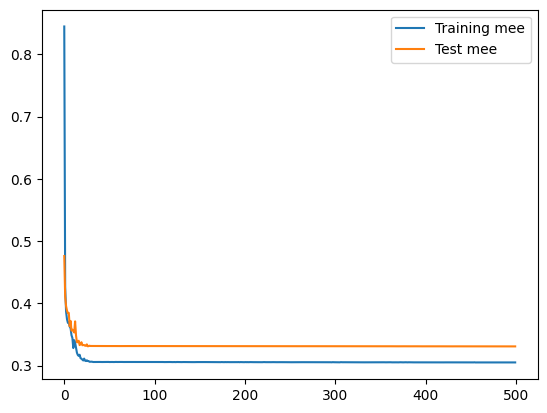

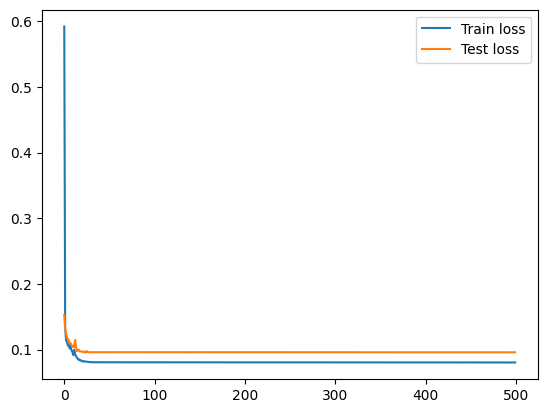

5/5 [==============================] - 0s 1ms/step
Train MSE: 3.5512237516864893
Train MEE: 1.5053416740349013
Test MSE: 4.164079171445688
Test MEE: 1.5965604677209821


In [78]:
model = grid_search(params, x_train, y_train, hold_out_val, x_test, y_test)
assess_model(model, x_train, y_train, x_test, y_test, True)

42/42 [==============================] - 0s 1ms/step


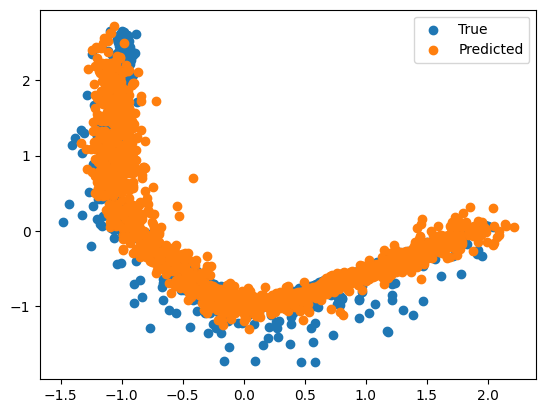

In [66]:
# y_train_rescaled = scaler.inverse_transform(y_train)
# print(y_train.shape)

plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
pred = model.predict(x_train)
# pred = scaler.inverse_transform(pred)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()